In [65]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [342]:
genome_metadata_df = load_genome_metadata(refseq_only=True)

model_organisms = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 
model_organisms += list(genome_metadata_df[(genome_metadata_df.checkm_completeness == 100)].drop_duplicates('class').species)
print('Number of reference genomes:', len(model_organisms)) # All of these organisms use the default translation table. 

genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(model_organisms)]

ncbi = NCBIDatasets()
ncbi.run(genome_metadata_df.index)
ncbi.cleanup()

# prod = Prodigal()
# for path in glob.glob('../data/genomes/*'):
#     prod.run(path)

Number of reference genomes: 141


NCBIDatasets.run: Downloading data for GCF_000426505.1.:  15%|█▍        | 21/141 [01:06<05:18,  2.65s/it]

NCBIDatasets.run: Failed to download data for GCF_000426005.1.


NCBIDatasets.run: Downloading data for GCF_005080965.1.:  49%|████▉     | 69/141 [05:07<02:51,  2.39s/it]

NCBIDatasets.run: Failed to download data for GCF_003751275.1.


NCBIDatasets.run: Downloading data for GCF_000214595.1.:  55%|█████▌    | 78/141 [06:16<05:59,  5.70s/it]

NCBIDatasets.run: Failed to download data for GCF_000023645.1.


NCBIDatasets.run: Downloading data for GCF_003574425.1.:  72%|███████▏  | 101/141 [08:08<02:02,  3.07s/it]

NCBIDatasets.run: Failed to download data for GCF_000014905.1.


NCBIDatasets.run: Downloading data for GCF_900129075.1.: 100%|██████████| 141/141 [10:25<00:00,  4.44s/it]


In [348]:
prod = Prodigal()
for path in glob.glob('../data/genomes/*'):
    genome_id = get_genome_id(path)
    translation_table = genome_metadata_df[genome_metadata_df.index == genome_id].ncbi_translation_table.item()
    prod.run(path, translation_table=translation_table)

In [349]:
! ref -i ../data/prodigal/* --prodigal-output -o ../data/ref.out/ 

ref: Searching reference genome for GCF_903064525.1.: 100%|█| 137/137 [40:08<00:
ref: Search complete. Output written to ../data/ref.out/


In [314]:
refseq_cds_df = load_refseq(feature='CDS', genome_metadata_df=genome_metadata_df, load_existing='../data/refseq_cds.csv')
# refseq_cds_df.to_csv('../data/refseq_cds.csv')

In [261]:
def plot_refseq_cds_length_distribution(ax:plt.Axes, max_length:int=2000):
    df = remove_pseudogenes(refseq_cds_df.copy())
    lengths = df.seq.apply(len) # Store the original set of gene lengths.
    lengths = lengths[lengths < max_length]
    sns.kdeplot(lengths, ax=ax, label=f'all RefSeq (n={len(lengths)})', color='black')

In [ ]:
(refseq_cds_df.evidence_type == 'ab initio prediction').sum()
refseq_cds_df.evidence_type.value_counts()

evidence_type
similar to AA sequence    59740
protein motif             12114
ab initio prediction       7140
profile                      66
Name: count, dtype: int64

In [338]:
def fix_bsub_evidence(refseq_cds_df:pd.DataFrame):
    refseq_cds_bsub_df = refseq_cds_df[(refseq_cds_df.species == 'Bacillus subtilis')].copy()
    refseq_cds_df = refseq_cds_df[(refseq_cds_df.species != 'Bacillus subtilis')].copy()

    evidence_types = []
    for row in refseq_cds_bsub_df.itertuples():
        if ('Evidence 1' in row.note) or ('Evidence 2' in row.note):
            evidence_types.append('experiment')
        elif ('Evidence 4' in row.note) or ('Evidence 3' in row.note):
            evidence_types.append('similar to sequence')
        else:
            evidence_types.append('ab initio prediction')
    refseq_cds_bsub_df.loc[:, 'evidence_type'] = evidence_types
    return pd.concat([refseq_cds_df, refseq_cds_bsub_df])

refseq_cds_df = fix_bsub_evidence(refseq_cds_df)

evidence_type
experiment              2454
similar to sequence     1648
ab initio prediction     135
Name: count, dtype: int64

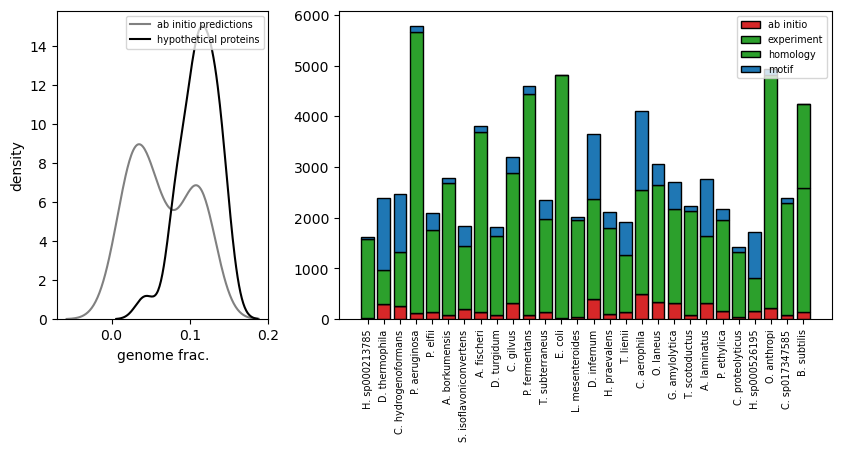

94816 bytes written to file /tmp/tmpb0nbg428/temp.png
load_ref_out: 100%|██████████| 49/49 [00:01<00:00, 33.94it/s]


In [339]:
def figure_1(refseq_cds_df:pd.DataFrame, path:str='../figures/errors-figure_1.png'):
    # Want to characterize the overall quality of the reference genomes, and possibly exclude some from analysis, depending on how heavily they 
    # are relying on ab initio tools. I should probably add more to this figure. 
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4), width_ratios=[0.3, 0.7])
    
    # Get the fraction of ab initio predicted CDS per genome... 
    fracs_ab_initio = refseq_cds_df.groupby('genome_id').apply(lambda df : (df['evidence_type'] == 'ab initio prediction').sum() / len(df), include_groups=False)
    fracs_hypothetical = refseq_cds_df.groupby('genome_id').apply(lambda df : df['product'].str.contains('hypothetical').sum() / len(df), include_groups=False)

    ax = axes[0]
    sns.kdeplot(fracs_ab_initio.values, color='gray', ax=ax, label='ab initio predictions')
    sns.kdeplot(fracs_hypothetical.values, color='black', ax=ax, label='hypothetical proteins')
    ax.legend(fontsize='x-small', loc='upper right')
    ax.set_ylabel('density')
    ax.set_xlabel('genome frac.')

    ax = axes[1]
    evidence_type_map = {'similar to AA sequence':'homology', 'similar to sequence':'homology', 'protein motif':'motif', 'ab initio prediction':'ab initio', 'alignment':'homology', np.nan:'none', 'profile':'motif'}
    color_map = {'homology':'tab:green', 'ab initio':'tab:red', 'motif':'tab:blue', 'none':'black', 'experiment':'tab:green'}
    
    refseq_cds_df['evidence_type'] = refseq_cds_df.evidence_type.replace(evidence_type_map)
    species = refseq_cds_df.species.unique()
    positions = np.arange(len(species))
    bottom = np.zeros(len(species))
    for evidence_type, df in refseq_cds_df.groupby('evidence_type'):
        heights = np.array([(df.species == species).sum() for species in species])
        ax.bar(positions, heights, color=color_map[evidence_type], edgecolor='black', label=evidence_type, bottom=bottom)
        bottom += heights
    ax.set_xticks(positions, labels=[f'{s.split()[0][0]}. {s.split()[1]}' for s in species], rotation=90, fontsize='x-small')
    ax.legend(fontsize='x-small')

    plt.savefig(path)
    plt.show()


def table_1(refseq_cds_df:pd.DataFrame, path:str='../figures/errors-table_1.png', max_frac_hypothetical:float=0.15):
    # fracs_ab_initio = refseq_cds_df.groupby('species', sort=False).apply(lambda df : (df['evidence_type'] == 'ab initio prediction').sum(), include_groups=False)
    fracs_hypothetical = refseq_cds_df.groupby('species', sort=False).apply(lambda df : df['product'].str.contains('hypothetical').sum() / len(df), include_groups=False)
    # table_df = pd.DataFrame({'frac. ab initio':fracs_ab_initio, 'frac. hypothetical':fracs_hypothetical})
    table_df = pd.DataFrame({'frac. hypothetical':fracs_hypothetical})
    table_df = table_df.sort_values(by='frac. hypothetical', ascending=True)
    table_df = table_df[table_df['frac. hypothetical'] < max_frac_hypothetical]
    dfi.export(table_df, path)
    return table_df


# Based on looking at the fraction of ab initio predictions in all of the 51 genomes I originally downloaded, I decided to work with a subset
# with the lowest fraction of ab initio predictions (less than 5 percent of the genome). 

figure_1(refseq_cds_df.copy())

model_organisms = table_1(refseq_cds_df).index
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(model_organisms)]

ref_out_df = load_ref_out(genome_metadata_df=genome_metadata_df)
refseq_cds_df = load_refseq(feature='CDS', genome_metadata_df=genome_metadata_df, load_existing='../data/refseq_cds.csv')




remove_pseudogenes: 1051 pseudogenes are present in the DataFrame.


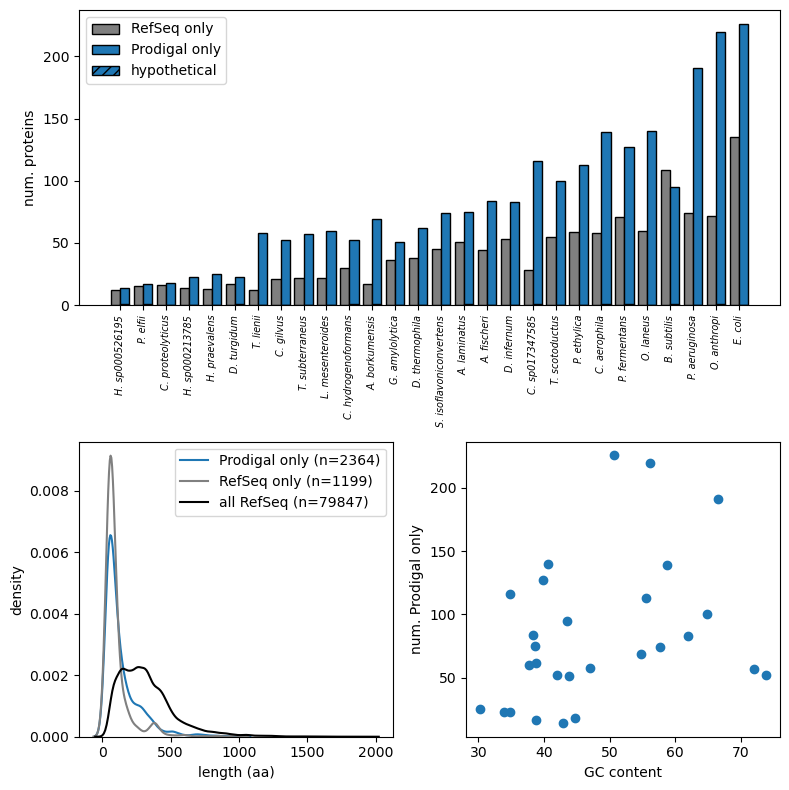

In [ ]:
# What are the lengths of the Prodigal predictions relative to the RefSeq sequences? They are essentially identical, so not worth plotting.
# What are the length distributions of Prodigal sequences which don't have a hit in RefSeq, and the ones in RefSeq that Prodigal missed?
# Is there any connection between genome characteristics, like GC content, and Prodigal performance?

def figure_2(ref_out_df:pd.DataFrame, refseq_cds_df:pd.DataFrame, max_length:int=1000, path:str='../figures/errors-figure_2.png'):


    fig = plt.figure(layout='tight', figsize=(8, 8))
    grid = GridSpec(nrows=2, ncols=2)

    ax_a = fig.add_subplot(grid[0, :])
    ax_b = fig.add_subplot(grid[1, 0])
    ax_c = fig.add_subplot(grid[1, 1])

    refseq_cds_df = refseq_cds_df[~refseq_cds_df.pseudo.astype(bool)] # Remove the pseudogenes.
    refseq_cds_df = refseq_cds_df[refseq_cds_df.seq.apply(len) < max_length]
    ref_out_df = ref_out_df[ref_out_df.seq.apply(len) < max_length]

    figure_df = dict()
    figure_df['frac_hypothetical'] = refseq_cds_df.groupby('genome_id').apply(lambda df : df['product'].str.contains('hypothetical').sum() / len(df), include_groups=False)

    refseq_cds_df = refseq_cds_df[~refseq_cds_df.protein_id.isin(ref_out_df.ref_protein_id)]
    ref_out_df = ref_out_df[ref_out_df.ref_protein_id.isnull()]
    
    figure_df['Prodigal only'] = ref_out_df.groupby('genome_id', sort=False).apply(len, include_groups=False)
    figure_df['RefSeq only'] = refseq_cds_df.groupby('genome_id', sort=False).apply(len, include_groups=False)
    figure_df = pd.DataFrame(figure_df)

    figure_df = figure_df.merge(refseq_cds_df[['species', 'genome_id', 'gc_percentage']].drop_duplicates('genome_id'), left_index=True, right_on='genome_id')
    figure_df = figure_df.set_index('genome_id')
    figure_df['species'] = [f'{s.split()[0][0]}. {s.split()[1]}' for s in figure_df.species]
    figure_df['total'] = figure_df['Prodigal only'] + figure_df['RefSeq only']
    figure_df = figure_df.sort_values('total', ascending=True, ignore_index=False)

    bar_width = 0.4
    colors = ['tab:gray', 'tab:blue']
    labels = ['RefSeq only', 'Prodigal only']
    positions = np.arange(len(figure_df))
    for i, label in enumerate(labels):
        heights = figure_df[label].values
        ax_a.bar(positions + i * bar_width, heights, width=bar_width,  color=colors[i], edgecolor='black', label=label)

    n_hypothetical = refseq_cds_df.groupby('genome_id').apply(lambda df : df['product'].str.contains('hypothetical').sum() / len(df), include_groups=False)
    n_hypothetical.name = 'n_hypothetical'
    figure_df = figure_df.merge(n_hypothetical, left_index=True, right_index=True)

    heights = figure_df.n_hypothetical
    ax_a.bar(positions + bar_width, heights, width=bar_width,  color=colors[1], edgecolor='black', label='hypothetical', hatch='///')

    ax_a.set_xticks(positions + bar_width / 2, labels=figure_df.species, fontsize='x-small', style='italic', rotation=90)   
    ax_a.legend()
    ax_a.set_ylabel('num. proteins')


    sns.kdeplot(ref_out_df.seq.apply(len), ax=ax_b, label=f'Prodigal only (n={len(ref_out_df)})', color='tab:blue')
    sns.kdeplot(refseq_cds_df.seq.apply(len), ax=ax_b, label=f'RefSeq only (n={len(refseq_cds_df)})', color='gray')
    plot_refseq_cds_length_distribution(ax_b)
    ax_b.set_ylabel('density')
    ax_b.set_xlabel('length (aa)')
    ax_b.legend()

    ax_c.scatter(figure_df.gc_percentage, figure_df['Prodigal only'], color='tab:blue', label='GC percentage')
    ax_c.set_ylabel('num. Prodigal only')
    ax_c.set_xlabel('GC content')

    plt.savefig(path)
    plt.show()


figure_2(ref_out_df, refseq_cds_df)

In [226]:
def is_n_trunc(row):
    return ((row.start > row.ref_start) and (row.strand == 1)) or ((row.stop < row.ref_stop) and (row.strand == -1)) 

def is_c_trunc(row):
    return ((row.stop < row.ref_stop) and (row.strand == 1)) or ((row.start > row.ref_start) and (row.strand == -1)) 

def is_n_ext(row):
    return ((row.start < row.ref_start) and (row.strand == 1)) or ((row.stop > row.ref_stop) and (row.strand == -1)) 

def is_c_ext(row):
    return ((row.stop > row.ref_stop) and (row.strand == 1)) or ((row.start < row.ref_start) and (row.strand == -1)) 


ref_out_df['c_trunc'] = ref_out_df.apply(is_c_trunc, axis=1)
ref_out_df['n_trunc'] = ref_out_df.apply(is_n_trunc, axis=1)
ref_out_df['n_ext'] = ref_out_df.apply(is_n_ext, axis=1)
ref_out_df['c_ext'] = ref_out_df.apply(is_c_ext, axis=1)

ref_out_df = remove_partial(ref_out_df)
ref_out_df['contains_sec'] = [False if pd.isnull(seq) else ('U' in seq) for seq in ref_out_df.ref_seq]

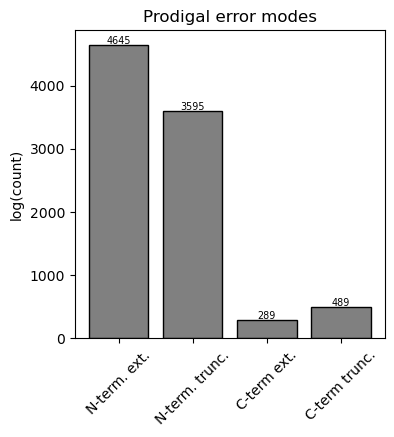

In [230]:
# Are there any patterns in the types of genes Prodigal tends to truncate?

fig, ax = plt.subplots(figsize=(4, 4))

labels = ['N-term. ext.', 'N-term. trunc.', 'C-term ext.', 'C-term trunc.'] 
heights = [ref_out_df.n_ext.sum(), ref_out_df.n_trunc.sum(), ref_out_df.c_ext.sum(), ref_out_df.c_trunc.sum()]
positions = np.arange(len(heights))

ax.bar(positions, heights, edgecolor='black', color='gray')
ax.set_title('Prodigal error modes')
ax.set_ylabel('log(count)')
ax.set_xticks(positions, labels=labels, rotation=45)
# ax.set_yscale('log')

for x, y in zip(positions, heights):
    ax.text(x, y + 20, str(y), ha='center', fontsize='x-small')

plt.show()



figure_4: Removing 1729 sequences which are in-frame hits, but not aligned at either end.
remove_hypothetical_proteins: Removing 8212 unannotated sequences.
remove_pseudogenes: 1051 pseudogenes are present in the DataFrame.
remove_pseudogenes: 1051 pseudogenes are present in the DataFrame.


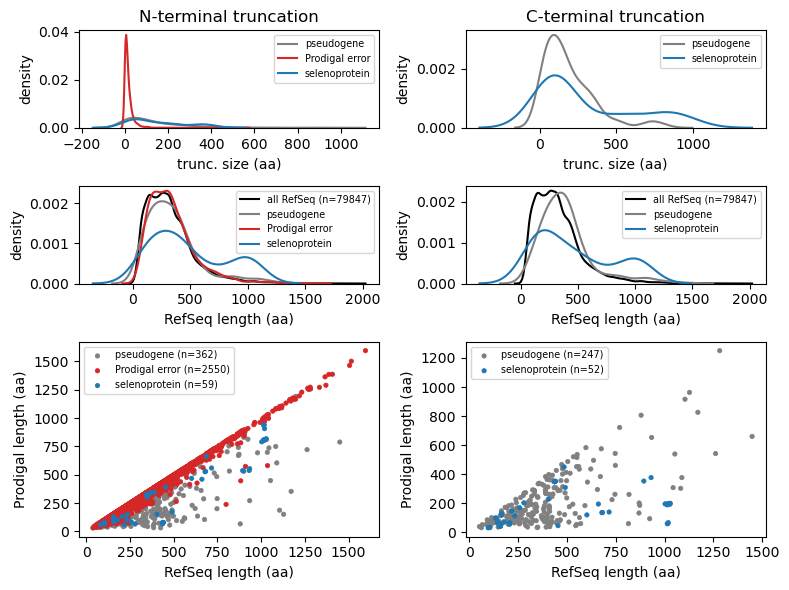

In [265]:
def figure_4(ref_out_df:pd.DataFrame, remove_hypothetical:bool=True, max_length:int=2000, min_trunc_size:int=0):

    fig, axes = plt.subplots(ncols=2, nrows=3, layout='tight', sharey=False, figsize=(8, 6), height_ratios=[0.25, 0.25, 0.5])
    axes[0, 0].set_title('N-terminal truncation')
    axes[0, 1].set_title('C-terminal truncation')
    color_map = {'selenoprotein':'tab:blue', 'Prodigal error':'tab:red', 'pseudogene':'gray'}

    # Filter out the hits which were in-frame, but not aligned at either end.
    mask = (ref_out_df.start_aligned_hit | ref_out_df.stop_aligned_hit)
    print(f'figure_4: Removing {(~mask).sum()} sequences which are in-frame hits, but not aligned at either end.') 
    ref_out_df = ref_out_df[mask].copy()

    if remove_hypothetical:
        ref_out_df = remove_hypothetical_proteins(ref_out_df.copy())

    def get_categories(df:pd.DataFrame):
        categories = []
        for row in df.astype({'ref_pseudo':bool}).itertuples():
            if row.contains_sec:
                categories.append('selenoprotein')
            elif row.ref_pseudo:
                categories.append('pseudogene')
            else:
                categories.append('Prodigal error')
        return pd.Categorical(categories, ['pseudogene', 'Prodigal error', 'selenoprotein'])

    ref_out_trunc_dfs = list()
    for df in [ref_out_df[ref_out_df.n_trunc].copy(), ref_out_df[ref_out_df.c_trunc].copy()]:
        df.loc[:, 'trunc_size'] = (df.ref_stop - df.ref_start) - (df.stop - df.start)
        df.loc[:, 'prodigal_length'] = (df.stop - df.start) // 3 + 1
        df.loc[:, 'refseq_length'] = (df.ref_stop - df.ref_start) // 3 + 1
        df.loc[:, 'category'] = get_categories(df)
        if max_length is not None:
            df = df[df.refseq_length < max_length]
        df = df[df.trunc_size > min_trunc_size]
        ref_out_trunc_dfs.append(df)

    for ax, df in zip(axes[0], ref_out_trunc_dfs):
        for cat, df_ in df.groupby('category', observed=True):
            sns.kdeplot(df_.trunc_size // 3 + 1, ax=ax, color=color_map[cat], label=cat)
        ax.set_xlabel('trunc. size (aa)')
        ax.set_ylabel('density')
        ax.legend(fontsize='x-small')

    for ax, df in zip(axes[1], ref_out_trunc_dfs):
        plot_refseq_cds_length_distribution(ax, max_length=max_length)
        for cat, df_ in df.groupby('category', observed=True):
            sns.kdeplot(df_.refseq_length, ax=ax, color=color_map[cat], label=cat)
        ax.set_xlabel('RefSeq length (aa)')
        ax.set_ylabel('density')
        ax.legend(fontsize='x-small')


    for ax, df in zip(axes[2], ref_out_trunc_dfs):
        for cat, df_ in df.groupby('category', sort=True, observed=True):
            # ax.scatter(df.refseq_length, df.trunc_size // 3 + 1, color=colors, s=5)
            colors = ['white' if (row.ref_product == 'hypothetical protein') else color_map[cat] for row in df_.itertuples()]
            ax.scatter(df_.refseq_length, df_.prodigal_length, color=colors, edgecolors=color_map[cat], s=10, lw=0.5, label=f'{cat} (n={len(df_)})')
        ax.legend(fontsize='x-small')
        ax.set_ylabel('Prodigal length (aa)')
        ax.set_xlabel('RefSeq length (aa)')

    plt.savefig()
    plt.show()

figure_4(ref_out_df)

In [ ]:
# I want to build a dataset of Prodigal spurious sequences versus short Prodigal predictions with a high degree of alignment
# to a sequence in the reference genome. 
ref_out_df = 

In [340]:
# Focusing on the C-terminal truncations, what are the stop codons which are read through?
# What amino acid is present in place of the read-through stop codon?

def get_missed_aas(df:pd.DataFrame):
    # It seems as though sometimes the truncation does not line up with the expected amino acid (I checked this with selenoproteins),
    # which I think is probably due to a stop codon immediately next to it. 
    aas = list()
    for row in df.itertuples():
        trunc_size = ((row.ref_stop - row.ref_start) - (row.stop - row.start)) // 3 # Truncation size in amino acids.
        if pd.isnull(row.ref_seq): # If it is a pseudogene...
            aa = None
        elif row.n_trunc:
            aa = row.ref_seq[int(trunc_size)]
        elif row.c_trunc:
            aa = row.ref_seq[-int(trunc_size)]
        aas.append(aa)
    df.loc[:, 'missed_aa'] = aas
    return df


# ref_out_c_trunc_df[['stop_codon', 'ref_stop_codon']]
# ref_out_c_trunc_df.stop_codon.value_counts()
# ref_out_c_trunc_df.ref_stop_codon.value_counts()


# ref_out_c_trunc_df = get_missed_aas(ref_out_c_trunc_df.copy())
# ref_out_c_trunc_df.missed_aa.value_counts()
# # ref_out_c_trunc_df[ref_out_c_trunc_df.missed_aa == 'G'][['missed_aa', 'stop_codon']]
# ref_out_n_trunc_df = get_missed_aas(ref_out_n_trunc_df.copy())
# ref_out_n_trunc_df.get_missed_aas.value_counts()

# stop_codons = ['TAA', 'TAG', 'TGA']
# start_codons = ['ATG', 'GTG', 'TTG']


In [242]:
# Maybe plot some kind of confusion matrix thing showing the frequency of different boundary errors. 
# The current state of the reference genome search does not detect cases where there is both a truncation and extension. 

# row_labels = ['N-term. ext.', 'N-term. trunc.']
# col_labels = ['C-term ext.', 'C-term trunc.']

# matrix = np.zeros((2, 2))
# matrix[0][0] = (ref_out_df.n_ext & ref_out_df.c_ext).sum()
# matrix[0][1] = (ref_out_df.n_ext & ref_out_df.c_trunc).sum()
# matrix[1][0] = (ref_out_df.n_trunc & ref_out_df.c_ext).sum()
# matrix[1][1] = (ref_out_df.n_trunc & ref_out_df.c_trunc).sum()
# matrix = pd.DataFrame(matrix, index=row_labels, columns=col_labels)
# matrix = matrix.astype(int)

In [ ]:
ref_out_df.ref_seq.str.match('nan').sum()

0

In [ ]:
ref_c_trunc_df[ref_c_trunc_df.ref_pseudo.astype(bool)][['ref_pseudo', 'ref_internal_stop', 'ref_frameshifted', 'start_codon']]
ref_out_c_trunc_df[ref_out_c_trunc_df.ref_pseudo.astype(bool)].value_counts('start_codon')
# ['ATG', 'GTG', 'TTG']

start_codon
ATG    800
GTG     65
TTG     46
ATT      1
Name: count, dtype: int64